# Step1. About this problem
A GAN consists of at least two neural networks: a generator model and a discriminator model. <br>

The generator is a neural network that creates the images. In this problem, we’re challenged to build a machine learning model that generate images in the style of Monet. This generator is trained using a discriminator.The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.<br>

     - Type of learning : Unsupervised learning
     - Type of task     : To build a GAN that generates 7,000 to 10,000 Monet-style images.
     - Data type        : Computer vision
   source: https://www.kaggle.com/competitions/gan-getting-started

# Step2. Exploratory Data Analysis (EDA)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from kaggle_datasets import KaggleDatasets
%matplotlib inline

import cv2

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, ReLU, ZeroPadding2D, GroupNormalization, Concatenate, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

2024-04-22 13:40:05.669442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 13:40:05.669550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 13:40:05.822115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Inspect TFRecord files
In this problem, there are two types of input data: "TFRecord type" files and "JPEG type" files.<br>
At first, I checked the "TFRecord type" files.

In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()
monet_files= tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
photo_files= tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

In [4]:
print('No. of Monet TFRecord files: ',len(monet_files))
print('No. of Photo TFRecord files: ',len(photo_files))

No. of Monet TFRecord files:  5
No. of Photo TFRecord files:  20


In [5]:
IMAGE_SIZE= [256,256]                                       # required size of image

def decode_img(image):                                      # function for decoding the image present in jpeg format
    image= tf.image.decode_jpeg(image,channels= 3)          # 3 channels because of RGB
    image= (tf.cast(image, tf.float32)/255)*2 -1            # converting the pixel values in range [-1,1]
    image= tf.reshape(image, shape= [*IMAGE_SIZE,3])        # reshaping the image to proper size
    return image

def read_tfrec(example):                                    # function for extracting image from TFRecord format
    tfrec_format= {
        'image_name': tf.io.FixedLenFeature([], tf.string), # [] denotes fixed length feature where length= 1
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string)
    }
    example= tf.io.parse_single_example(example, tfrec_format) # TFRecord can be read using tf.parse_single_example.
    image= decode_img(example['image'])
    return image

In [6]:
def load_data(files):
    data= tf.data.TFRecordDataset(files)
    data= data.map(read_tfrec)                        # (num_parallel_calls= AUTOTUNE) in  case of TPU
    return data

In [7]:
monet_data= load_data(monet_files).batch(1)           # forming batches of size=1 (i.e. 1 image processed at a time)
photo_data= load_data(photo_files).batch(1)

In [8]:
monet_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [9]:
# Floowing code is uesd to see the contents of the above data

#for item in monet_data:
#    print(item)

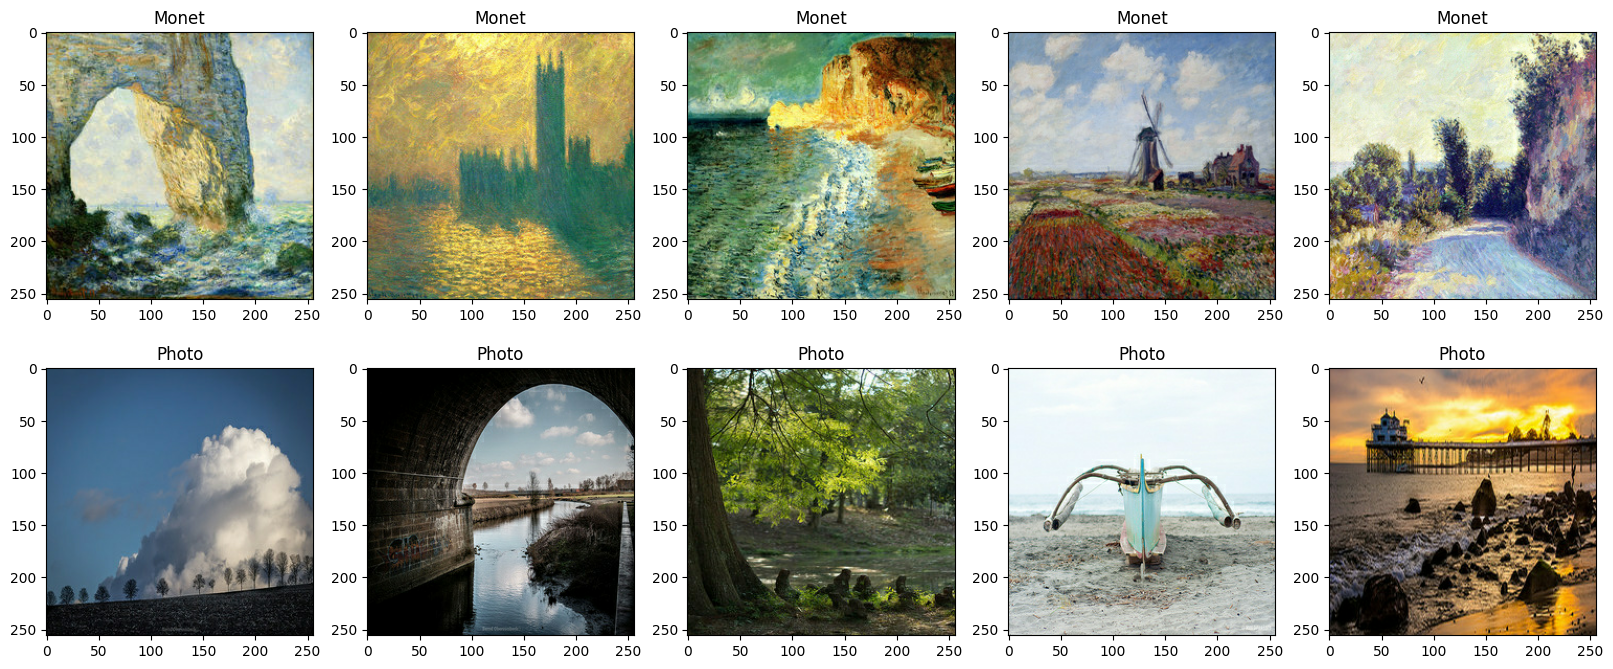

In [10]:
list_monet = iter(monet_data)
list_photo = iter(photo_data)

plt.figure(figsize=(20,8))

for i in range(1,6):
    ex_monet = next(list_monet)          # The next() function gets the next element from that iterator
    plt.subplot(2,5,i)                   # creating a subplot with 2 row and 5 columns
    plt.title('Monet')
    plt.imshow(ex_monet[0]*0.5 +0.5)     # rescaling the image to [0,1] for displaying
                                         # ex_monet[0] is the pixel data of the image
    ex_photo = next(list_photo)
    plt.subplot(2,5,i+5)                 
    plt.title('Photo')
    plt.imshow(ex_photo[0]*0.5 +0.5)                         

-> Top row : Monet samples<br>
-> Bottom row : Photo samples

## Inspect JPEG files
Next, I checked the "JPEG type" files.

In [11]:
monet_files2= tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
photo_files2= tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))

In [12]:
monet_files2[0]

'gs://kds-46f965b8d6bc7b09354319bda07156cc3a0fb0b331f3e01e3154fbec/monet_jpg/000c1e3bff.jpg'

In [13]:
print('No. of Monet JPEG files: ',len(monet_files2))
print('No. of Photo JPEG files: ',len(photo_files2))

No. of Monet JPEG files:  300
No. of Photo JPEG files:  7038


-> The number of JPEG files is larger than that of TFRecord files. 

In [14]:
list_monet = []
list_photo = []

for dirname, _, filenames in os.walk('/kaggle/input/gan-getting-started/monet_jpg/'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        list_monet.append(os.path.join(dirname, filename))
        
monet_data2 = [cv2.imread(filename) for filename in list_monet]


for dirname, _, filenames in os.walk('/kaggle/input/gan-getting-started/photo_jpg/'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        list_photo.append(os.path.join(dirname, filename))
        
photo_data2 = [cv2.imread(filename) for filename in list_photo]

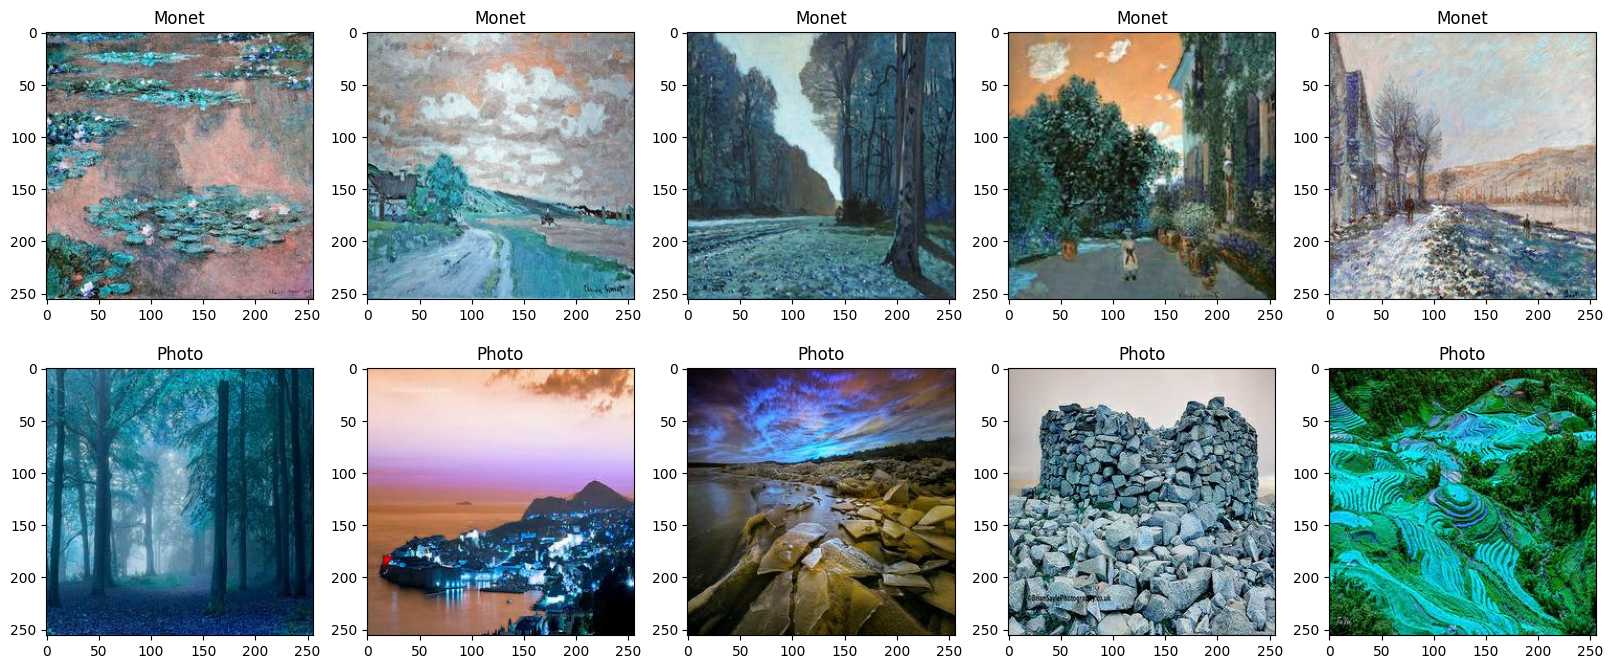

In [15]:
list_monet2 = iter(monet_data2)
list_photo2 = iter(photo_data2)

plt.figure(figsize=(20,8))

for i in range(1,6):
    ex_monet2 = next(list_monet2)         
    plt.subplot(2,5,i)                 
    plt.title('Monet')
    plt.imshow(ex_monet2)     
                                         
    ex_photo2 = next(list_photo2)
    plt.subplot(2,5,i+5)                 
    plt.title('Photo')
    plt.imshow(ex_photo2)           

-> As in the TFRecord file survey, the top row shows samples of the Monet and the bottom row shows samples of the photo.<br>
-> As a matter of course, both the TFRecord files and the JPG files contain the Monet pictures and photos.

# Step3. Building and training model.

## About Cycle GAN
CycleGAN was used to solve this proble. CycleGAN is an approach that transforms a particular image into another image.<br>
The model proposed in this paper: https://arxiv.org/pdf/1703.10593.pdf

In this model, a dataset X (Ex.Photo) and a dataset Y (Ex.Monet painting) are transformed into each other by Generator, and then authenticity is determined by Discriminator.

1. X is once converted to Y, and then a Discriminator determines whether the fake data in Y is real or not.<br> 
     GeneratorA convert X -> Y , DiscriminatorA check Y 
            
2. The transformed Y is reconverted back to X, and another Discriminator determines whether the reconverted X is the original image or the converted image.<br>
     GeneratorB convert Y -> X , DiscriminatorB check X  <br>

In other words, learning is performed in such a way as to minimize two types of loss: <br>
 - Adversarial Loss, which is used in normal GAN
 - Cycle Consistency Loss, which is the loss when the image is restored in cycles

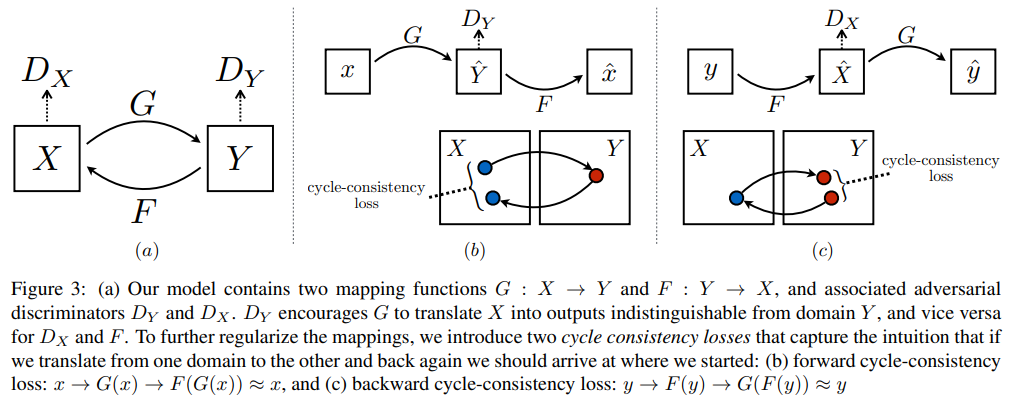

This makes it possible to achieve the image transformation described above even with unsupervised learning without using paired images.


## About Model architecture
For this CycleGAN architecture, UNET is uesd. UNET is a type of fully convolution network.
Roghly, it uses downsample to obtain the location of objects in the image and upsample to obtain the features of the objects (the name of the network seems to come from the fact that the structure of downsample and upsample resembles the letter "U" in the alphabet).<br>
[Image of UNET] 
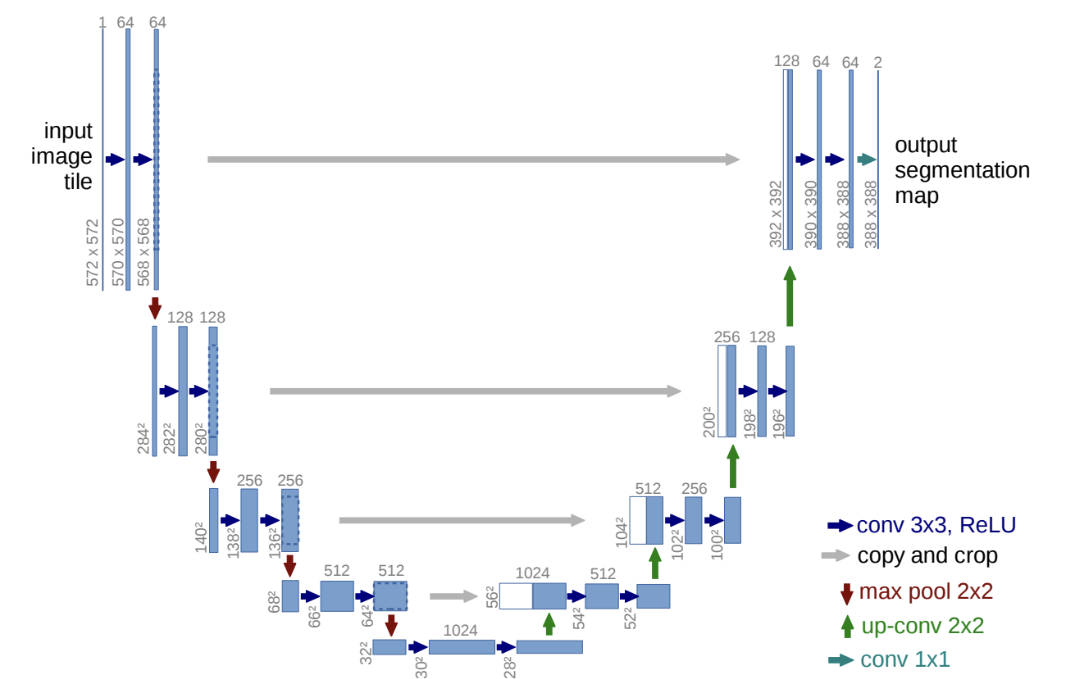
source : https://arxiv.org/pdf/1505.04597.pdf

The following functions were used to create the model:<br>

### Downsample
As the name implies (sampling downward), downsample downsizes the two dimensions of the image, height and width, along the stride.The stride is the length of steps taken by the filter (a small area in the convolution).In this case, the stride is 2, so the filter is applied to all pixels and the height and width are reduced by 2.

### Upsample
It increases the dimensionality inversely to downsample.
Conv2DTranspose performs inverse convolution.

### Generator
The input image of generator is downsampled and upsampled.
At this time, skip connections are created. Skip connections prevent gradient problems, in this case, the loss of object location information during downsample, by recording multiple objects and connecting them to the output layer.

### Discriminator
The discriminator takes an input image and discriminates between real and fake (intentionally generated) images.

### CycleGAN
In training, the model performs a "photo → Monet-style painting → photo" conversion. The difference between the first original photo and the second photo is cycle-consistency loss. The objective is to reduce these differences.

### Loss Function
Since this is a binary classification problem, Binary Cross Entropy is used. We want the original and retransformed photos to be close, Cycle Consistency Loss was used to compute the average of the differences.

In [16]:
def downsample(filters, size, instance_norm= True):     # for extracting important features (size is reduced)
    initializer= tf.random_normal_initializer(0,0.02)   
    
    # mean=0 and standard deviation=0.02 for initializing kernel weights
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    
    model= keras.Sequential()                                          
    model.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer= initializer, use_bias= False))
    
    if instance_norm:
         model.add(GroupNormalization(groups= -1, gamma_initializer= gamma_init))     
         # groups= -1 to make it work like Instance Normalization
   
    model.add(LeakyReLU())
    
    return model

In [17]:
def upsample(filters, size, dropout= False):           # for locating features accurately using skip connections 
    initializer= tf.random_normal_initializer(0,0.02)
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    
    model= keras.Sequential()
    model.add(Conv2DTranspose(filters, size, strides= 2, padding= 'same', kernel_initializer= initializer, use_bias= False))
    model.add(GroupNormalization(groups= -1, gamma_initializer= gamma_init))
    
    if dropout:
        model.add(Dropout(0.5))
    
    model.add(ReLU())
    
    return model

In [18]:
def generator():
    down_stack= [
        downsample(64,4,False),                 # size= (128,128,64)  (size denotes the dimensions of image after the corresponding layer/operation)
        downsample(128,4),                      # size= (64,64,128)
        downsample(256,4),                      # size= (32,32,256)
        downsample(512,4),                      # size= (16,16,512)
        downsample(512,4),                      # size= (8,8,512)
        downsample(512,4),                      # size= (4,4,512)
        downsample(512,4),                      # size= (2,2,512)
        downsample(512,4),                      # size= (1,1,512)
    ]
    
    up_stack= [
        upsample(512,4,True),                   # size= (2,2,1024)  (no. of channels doubled because upsample block concats output of last downsample block)    
        upsample(512,4,True),                   # size= (4,4,1024)
        upsample(512,4,True),                   # size= (8,8,1024)
        upsample(512,4),                        # size= (16,16,1024)  (dropout= false so that information is maintained for generating detailed outputs)
        upsample(256,4),                        # size= (32,32,512)
        upsample(128,4),                        # size= (64,64,256)
        upsample(64,4)                          # size= (128,128,128)
    ]
    
    initializer= tf.random_normal_initializer(0,0.02)
    last_layer= Conv2DTranspose(3, 4, strides= 2, padding= 'same', kernel_initializer= initializer, activation= 'tanh')     # 3 output channels required
    
    i= Input(shape= [256,256,3])                # input layer
    x= i
    skips= []
    for down in down_stack:                     # downsampling
        x= down (x) 
        skips.append(x)                         # appending skip connections to the 'skips' list
        
    skips= reversed(skips[:-1])                 # last skip connection is not used because of alignment with upsampling path
    
    for up, skip in zip(up_stack,skips):        # upsampling and concatenating output with skip connection
        x= up (x)
        x= Concatenate() ([x,skip])
        
    x= last_layer(x)                            # last layer (Conv2DTranspose) for generating the final output 
    
    model= Model(i,x)
    
    return model

In [19]:
def discriminator():
    i= Input(shape= [256,256,3])
    x= downsample(64,4) (i)                                 # size= (128,128,64) 
    x= downsample(128,4) (x)                                # size= (64,64,128) 
    x= downsample(256,4) (x)                                # size= (32,32,256)
    
    x= ZeroPadding2D() (x)                                  # size= (34,34,256)    (1 pixel padding is added at top,bottom,left,right) 
    
    initializer= tf.random_normal_initializer(0,0.02)
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    x= Conv2D(512, 4, strides= 1, padding= 'same', kernel_initializer= initializer, use_bias= False) (x)      # size= (31,31,512) (size= orig - kernel + 1)
    x= GroupNormalization(groups= -1, gamma_initializer= gamma_init) (x)
    x= LeakyReLU() (x)
    
    x= ZeroPadding2D() (x)                                  # size= (33,33,512)    (zero padding applied to maintain spatial information)
    
    x= Conv2D(1, 4, strides= 1, padding= 'same', kernel_initializer= initializer) (x)       # size= (30,30,1) 
                                                                                            # sigmoid not used to output unbounded logits
    model= Model(i,x)                                                                       # (more numerically stable during training)
    
    return model

In [20]:
monet_generator= generator()            # photo to monet-esque
monet_discriminator= discriminator()    # to differentiate between generated monet-esque images and real monet-esque images
photo_generator= generator()            # monet-esque to photo
photo_discriminator= discriminator()    # to differentiate between generated 'normal' images and real 'normal' images

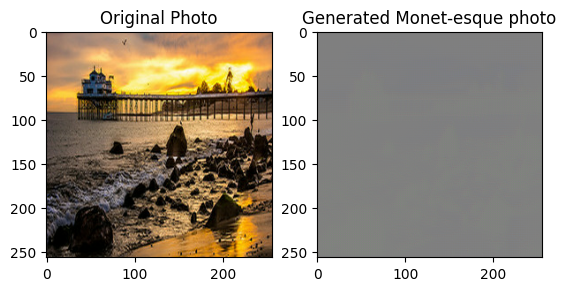

In [21]:
photo_to_monet= monet_generator(ex_photo)  
# won't generate monet-esque photos as we have not fit the data into generator yet

plt.subplot(1,2,1)                   # creating a subplot with 1 row and 2 columns
plt.title('Original Photo')
plt.imshow(ex_photo[0]*0.5 +0.5)     # rescaling the image to [0,1] for displaying

plt.subplot(1,2,2)
plt.title('Generated Monet-esque photo')
plt.imshow(photo_to_monet[0]*0.5 +0.5)              

In [22]:
class CycleGAN(keras.Model):    
# CycleGAN class inheriting from keras.Model class so that it can use its methods to train, compile etc.

    def __init__(               # arguments to be passed in a CycleGAN class object   
        self,
        monet_gen,
        monet_disc,
        photo_gen,
        photo_disc,
        lambda_cycle= 10        # 'lambda_cycle' controls the importance of cycle consistency loss
    ):
        super(CycleGAN,self).__init__()     
        # calls the constructor of the parent class (keras.Model), initializing the base properties and methods
        # assigning argument values to attributes of a CycleGAN class object/instance
        self.m_gen= monet_gen               
        self.m_disc= monet_disc
        self.p_gen= photo_gen
        self.p_disc= photo_disc
        self.lambda_cycle= lambda_cycle
        
    def compile(                                   
        self,
        m_gen_optimizer,
        m_disc_optimizer,
        p_gen_optimizer,
        p_disc_optimizer,
        gen_loss_function,
        disc_loss_function,
        cycle_loss_function,
        identity_loss_function
    ):
        super(CycleGAN,self).compile()             
        # calls the 'compile' fn of the parent class (keras.Model), initializing the base properties and methods
        self.m_gen_optimizer = m_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_function = gen_loss_function
        self.disc_loss_function = disc_loss_function
        self.cycle_loss_function = cycle_loss_function
        self.identity_loss_function = identity_loss_function
        
    def train_step(self,batch_data):                                
        # automatically invoked when fit() method is called 
        real_monet, real_photo= batch_data
        
        with tf.GradientTape(persistent= True) as tape:             
        # to keep a track of operations (persistent= True bcz of multiple calls to Gradient())
            
            fake_monet= self.m_gen(real_photo, training= True)      # photo to monet and then cycled back to photo
            cycled_photo= self.p_gen(fake_monet, training= True)
            
            fake_photo= self.p_gen(real_monet, training= True)      # monet to photo and then cycled back to monet
            cycled_monet= self.m_gen(fake_photo, training= True)
            
            same_photo= self.p_gen(real_photo, training= True)      # generating itself (useful in calculating identity loss)
            same_monet= self.m_gen(real_monet, training= True)      
            
            disc_real_photo= self.p_disc(real_photo, training= True)   # discriminator used to check by inputing real images
            disc_real_monet= self.m_disc(real_monet, training= True)   
            
            disc_fake_photo= self.p_disc(fake_photo, training= True)   # discriminator used to check by inputing fake images
            disc_fake_monet= self.m_disc(fake_monet, training= True)
            
            gen_monet_loss= self.gen_loss_function(disc_fake_monet)    # generator loss
            gen_photo_loss= self.gen_loss_function(disc_fake_photo)
            
            total_cycle_loss = (self.cycle_loss_function(real_monet, cycled_monet, self.lambda_cycle) +     # total cycle consistency loss
            self.cycle_loss_function(real_photo, cycled_photo, self.lambda_cycle))
            
            total_gen_monet_loss= (gen_monet_loss + total_cycle_loss   +                                    # total generator monet loss
            self.identity_loss_function(real_monet, same_monet, self.lambda_cycle) )  
            
            total_gen_photo_loss= (gen_photo_loss + total_cycle_loss   +                                    # total generator photo loss
            self.identity_loss_function(real_photo, same_photo, self.lambda_cycle) )
            
            disc_monet_loss= self.disc_loss_function(disc_real_monet, disc_fake_monet)                      # discriminator monet loss 
            disc_photo_loss= self.disc_loss_function(disc_real_photo, disc_fake_photo)                      # discriminator photo loss
            
            
        gen_monet_gradients= tape.gradient(total_gen_monet_loss, self.m_gen.trainable_variables)            # calculate gradients for generators
        gen_photo_gradients= tape.gradient(total_gen_photo_loss, self.p_gen.trainable_variables)            # diff loss fn wrt trainable variables of model
        
        disc_monet_gradients= tape.gradient(disc_monet_loss, self.m_disc.trainable_variables)               # calculate gradients for discriminators
        disc_photo_gradients= tape.gradient(disc_photo_loss, self.p_disc.trainable_variables)
        
        self.m_gen_optimizer.apply_gradients(zip(gen_monet_gradients, self.m_gen.trainable_variables))      # apply the gradients to optimizer
        self.p_gen_optimizer.apply_gradients(zip(gen_photo_gradients, self.p_gen.trainable_variables))      # basically performing gradient descent
        self.m_disc_optimizer.apply_gradients(zip(disc_monet_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(disc_photo_gradients, self.p_disc.trainable_variables))
        
        return {
            'gen_monet_loss': total_gen_monet_loss,
            'gen_photo_loss': total_gen_photo_loss,
            'disc_monet_loss': disc_monet_loss,
            'disc_photo_loss': disc_photo_loss
        }

In [23]:
def gen_loss_fn(generated): 
# from_logits=True used bcz disc return unbounded values & NONE redn used to return tensor of indiv losses bcz those values are returned at each epoch
    return BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)


def disc_loss_fn(real, generated):
    loss_real= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
    loss_fake= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)
    total_loss= (loss_real + loss_fake)/2
    return total_loss


def cycle_loss_fn(real, cycled, lambda_cycle):
    loss= tf.reduce_mean(tf.abs(real - cycled))
    return lambda_cycle*loss                   # lambda controls the weight of cycle consistency loss in overall loss 


def identity_loss_fn(real, same, Lambda):      # LAMBDA has same use as in case of cycle consistency loss
    loss= tf.reduce_mean(tf.abs(real - same))     
    return Lambda*loss*0.5                     # factor of '0.5' used for normalization purposes

In [24]:
m_gen_opt  = Adam(learning_rate= 2e-4, beta_1= 0.5)
m_disc_opt = Adam(learning_rate= 2e-4, beta_1= 0.5)

p_gen_opt  = Adam(learning_rate= 2e-4, beta_1= 0.5)
p_disc_opt = Adam(learning_rate= 2e-4, beta_1= 0.5)

In [25]:
cyclegan_model= CycleGAN(monet_generator, monet_discriminator, photo_generator, photo_discriminator, 10)
cyclegan_model.compile(m_gen_opt, m_disc_opt, p_gen_opt, p_disc_opt, gen_loss_fn, disc_loss_fn, 
                        cycle_loss_fn, identity_loss_fn)

In [26]:
cyclegan_model.fit(tf.data.Dataset.zip((monet_data, photo_data)), epochs= 20)

Epoch 1/20


I0000 00:00:1713793405.323729      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 191s 206ms/step - disc_monet_loss: 0.6593 - disc_photo_loss: 0.6260 - gen_monet_loss: 5.1447 - gen_photo_loss: 5.3398 - loss: 0.0000e+00
Epoch 2/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - disc_monet_loss: 0.6717 - disc_photo_loss: 0.5192 - gen_monet_loss: 3.6466 - gen_photo_loss: 4.0351 - loss: 0.0000e+00
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 211ms/step - disc_monet_loss: 0.6745 - disc_photo_loss: 0.5781 - gen_monet_loss: 3.5681 - gen_photo_loss: 3.9299 - loss: 0.0000e+00
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 211ms/step - disc_monet_loss: 0.6827 - disc_photo_loss: 0.4934 - gen_monet_loss: 3.4515 - gen_photo_loss: 4.0566 - loss: 0.0000e+00
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 211ms/step - disc_monet_loss: 0.6710 - disc_photo_loss: 0.5949 - gen_monet_loss: 3.3337 - gen_photo_loss: 3.7792 - loss: 0.0000e+00
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 211ms/step - disc_monet_loss: 0.6579 - disc_photo_loss: 0.6340 - gen_monet_loss: 3.1526 - gen_photo_loss: 3.3580 - loss: 0.0000e+00
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 211ms/step - disc_monet_loss: 0.6384 - disc_photo_loss: 0.6497 - gen_monet_loss: 3.1159

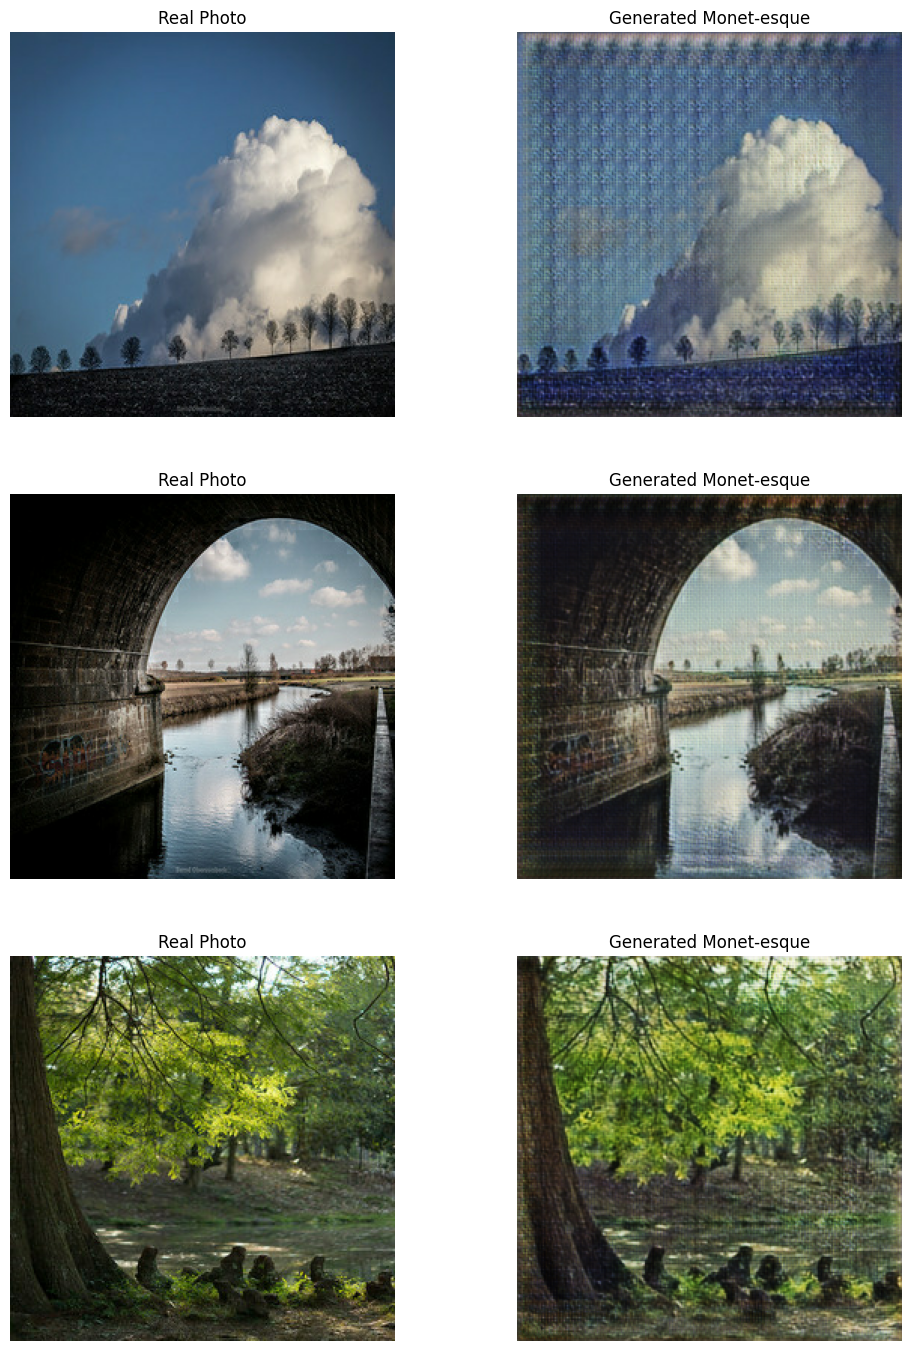

In [33]:
fig,ax= plt.subplots(3,2, figsize=(12,17))
for i,img in enumerate(photo_data.take(3)):
    pred= monet_generator(img, training= False)[0].numpy()   # training= False to make sure not to update model's weights
    pred= (pred*127.5 + 127.5).astype(np.uint8)              # making pixel range to [0,255]
    img= (img[0]*127.5 + 127.5).numpy().astype(np.uint8)
    
    ax[i,0].imshow(img)
    ax[i,1].imshow(pred)
    ax[i,0].set_title('Real Photo')
    ax[i,1].set_title('Generated Monet-esque')
    ax[i,0].axis('off')
    ax[i,1].axis('off')

# Step4. Create submission file¶

In [28]:
import PIL
!mkdir ../images

In [29]:
i = 1
for image in photo_data:
    pred = monet_generator(image, training=False)[0].numpy()
    pred = (pred*127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(pred)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [30]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

-> I got the score "61.8132".
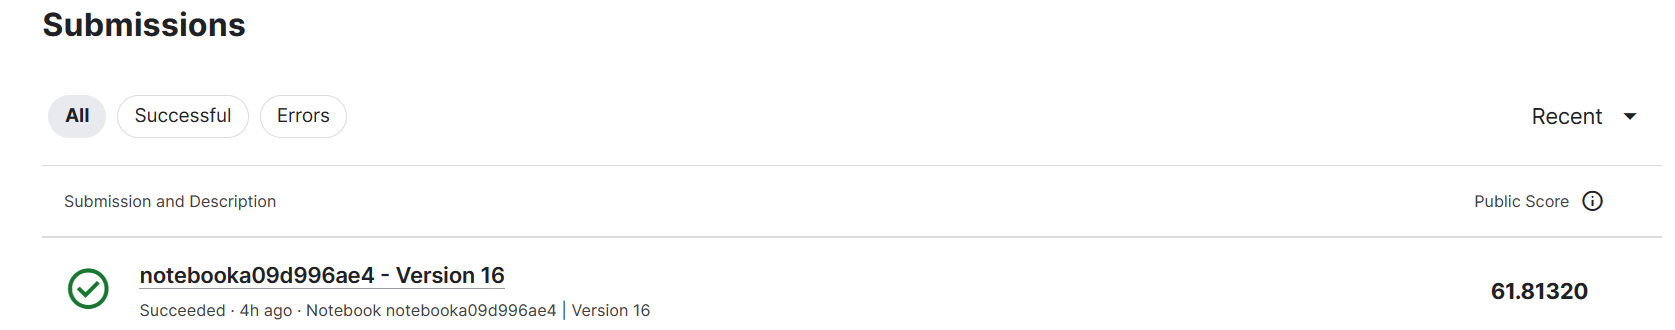

# Step5. Summary
I tried CycleGAN + UNET + TFRecord data to create a Monet-like image and got the kaggle score "61.8121".<br>
There are JPEG data in addition to TFRecord data. Although it was not possible to do so this time due to time constraints, I expect to improve the accuracy of the model by using them. It seems that there are also architectures that have ResNet other than UNET, and using them is one of the candidates for model improvement.

### Reference
The following notebook was used as a reference in creating this project. By referring to this notebook, I could understand very well how to create a model using CycleGAN.<br>
 https://www.kaggle.com/code/tarndeepsingh16/i-m-something-of-a-painter-myself